---

Name: Divani Rafitya
- [Dataset](https://www.kaggle.com/datasets/shivamb/real-or-fake-fake-jobposting-prediction/data)
- [Hugging Face](https://huggingface.co/spaces/divanirafitya/fake_job_postings)

---

# Business Understanding

Di era digital saat ini, banyak perusahaan yang memanfaatkan platform online untuk memposting lowongan kerja dan mencari calon karyawan. Namun, meningkatnya jumlah lowongan pekerjaan palsu di berbagai platform tidak hanya merugikan pencari kerja yang mencari peluang kerja tetapi juga merusak kredibilitas perusahaan yang ditiru.

Oleh karena itu, objective berdasarkan problem diatas adalah untuk dapat mengurangi risiko penipuan lowongan kerja dengan mengembangkan cara untuk mengidentifikasi dan menyaring postingan lowongan kerja palsu dengan lebih efisien.

Dalam hal ini, saya membuat deep learning model yang dapat mengidentifikasi postingan lowongan kerja palsu menggunakan Natural Language Preprocessing (NLP). Untuk mengevaluasi performa model, metrics classification akan menggunakan model recall dengan pertimbangan False Negative penting untuk diminimalisir, dimana false negatif adalah kondisi ketika job posting adalah penipuan tetapi hasil prediksinya adalah real job posting. Hal ini bertujuan untuk memastikan bahwa pencari kerja mendapatkan lowongan pekerjaan yang sesungguhnya dari perusahaan dan tidak kehilangan kesempatan untuk memperoleh pekerjaan yang layak.

# Import Libraries

In [1]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import files

# import preprocessing
import re
import nltk
import string
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer

# import tensorflow
import tensorflow as tf
import tensorflow_hub as tf_hub
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TextVectorization, Embedding, Dense, LSTM, Dropout, Reshape

# import warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [3]:
# # install libraries
# !pip install -q kaggle
# !pip install nltk
# !pip install tensorflow

# Data Loading

In [4]:
# download dataset from kaggle
!kaggle datasets download -d shivamb/real-or-fake-fake-jobposting-prediction

Dataset URL: https://www.kaggle.com/datasets/shivamb/real-or-fake-fake-jobposting-prediction
License(s): CC0-1.0
 31% 5.00M/16.1M [00:00<00:00, 27.7MB/s]
100% 16.1M/16.1M [00:00<00:00, 68.7MB/s]


In [5]:
# unzip file from kaggle
!unzip -q /content/real-or-fake-fake-jobposting-prediction.zip

In [6]:
# load dataset from .csv file
df_ori = pd.read_csv('fake_job_postings.csv')

In [7]:
# duplicate original dataset
df = df_ori.copy()

In [8]:
# show first 10 rows as sample
df.head(10)

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0
5,6,Accounting Clerk,"US, MD,",NaN,NaN,NaN,Job OverviewApex is an environmental consultin...,NaN,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,0
6,7,Head of Content (m/f),"DE, BE, Berlin",ANDROIDPIT,20000-28000,"Founded in 2009, the Fonpit AG rose with its i...",Your Responsibilities: Manage the English-spea...,Your Know-How: ...,Your Benefits: Being part of a fast-growing co...,0,1,1,Full-time,Mid-Senior level,Master's Degree,Online Media,Management,0
7,8,Lead Guest Service Specialist,"US, CA, San Francisco",NaN,NaN,Airenvy’s mission is to provide lucrative yet ...,Who is Airenvy?Hey there! We are seasoned entr...,"Experience with CRM software, live chat, and p...",Competitive Pay. You'll be able to eat steak e...,0,1,1,NaN,NaN,NaN,NaN,NaN,0
8,9,HP BSM SME,"US, FL, Pensacola",NaN,NaN,Solutions3 is a woman-owned small business who...,Implementation/Configuration/Testing/Training ...,MUST BE A US CITIZEN.An active TS/SCI clearanc...,NaN,0,1,1,Full-time,Associate,NaN,Information Technology and Services,NaN,0
9,10,Customer Service Associate - Part Time,"US, AZ, Phoenix",NaN,NaN,"Novitex Enterprise Solutions, formerly Pitney ...",The Customer Service Associate will be based i...,Minimum Requirements:Minimum of 6 months custo...,NaN,0,1,0,Part-time,Entry level,High School or equivalent,Financial Services,Customer Service,0


In [9]:
# show dataframe summary
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   job_id               17880 non-null  int64 
 1   title                17880 non-null  object
 2   location             17534 non-null  object
 3   department           6333 non-null   object
 4   salary_range         2868 non-null   object
 5   company_profile      14572 non-null  object
 6   description          17879 non-null  object
 7   requirements         15184 non-null  object
 8   benefits             10668 non-null  object
 9   telecommuting        17880 non-null  int64 
 10  has_company_logo     17880 non-null  int64 
 11  has_questions        17880 non-null  int64 
 12  employment_type      14409 non-null  object
 13  required_experience  10830 non-null  object
 14  required_education   9775 non-null   object
 15  industry             12977 non-null  object
 16  func

In [10]:
# check missing values in dataset
df.isnull().sum()

job_id                     0
title                      0
location                 346
department             11547
salary_range           15012
company_profile         3308
description                1
requirements            2696
benefits                7212
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         3471
required_experience     7050
required_education      8105
industry                4903
function                6455
fraudulent                 0
dtype: int64

In [11]:
# check for duplications in dataset
df.duplicated().sum()

0

Berdasarkan informasi di atas, insight yang diperoleh adalah sebagai berikut:
- Dataset ini terdiri dari `18 columns` dengan total `17880 data entries`.
- Teradpat ketidaksesuaian tipe data untuk column `'telecommuting', 'has_company_logo', dan 'has_questions'` yang seharusnya merupakan object karena datanya berupa categorical yang sudah encoded.
- Terdapat missing value pada dataset, yaitu pada column
`'location', 'department', 'salary_range', 'company_profile', 'description', 'requirements', 'benefits', 'employment_type', 'required_experience', 'required_education', 'industry', dan 'function'`.
- Tidak terdapat data duplicates dalam dataset.

## Data Cleaning

Pada data cleaning, pertama-tama saya akan drop column yang tidak terpakai terlebih dahulu. Dalam hal ini, column yang tidak terpakai adalah 'job_id' dan 'title' karena tiap valuenya unik jadi informasinya tidak signifikan.

In [12]:
# drop column
df.drop(['job_id','title'],axis= 1,inplace=True)

Pada data cleaning, pertama-tama saya akan melakukan handling missing values.
Dalam hal ini, kemungkinan adanya missing value pada column diatas didefinisikan sebagai `Missing Completely at Random (MCAR)`. Hal ini dikarenakan kemungkinan besar perusahaan merasa tidak nyaman untuk mengungkapkan lokasi perusahaanya sehingga sengaja membiarkan baris tersebut kosong.

Handling missing value akan dilakukan dengan menggunakan `fillna` karena saya tidak ingin kehilangan data yang akan digunakan untuk melakukan text processing.

In [13]:
# handling missing value with fillna
df = df.replace('Nan',np.nan)
df = df.fillna(' ')

In [14]:
# check missing value after data cleaning
df.isnull().sum()

location               0
department             0
salary_range           0
company_profile        0
description            0
requirements           0
benefits               0
telecommuting          0
has_company_logo       0
has_questions          0
employment_type        0
required_experience    0
required_education     0
industry               0
function               0
fraudulent             0
dtype: int64

In [15]:
# check dataframe after data cleaning
df.head()

,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,"US, NY, New York",Marketing,,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,,0,1,0,Other,Internship,,,Marketing,0
1,"NZ, , Auckland",Success,,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,,Marketing and Advertising,Customer Service,0
2,"US, IA, Wever",,,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,,0,1,0,,,,,,0
3,"US, DC, Washington",Sales,,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,"US, FL, Fort Worth",,,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [16]:
# check summary after data cleaning
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   location             17880 non-null  object
 1   department           17880 non-null  object
 2   salary_range         17880 non-null  object
 3   company_profile      17880 non-null  object
 4   description          17880 non-null  object
 5   requirements         17880 non-null  object
 6   benefits             17880 non-null  object
 7   telecommuting        17880 non-null  int64 
 8   has_company_logo     17880 non-null  int64 
 9   has_questions        17880 non-null  int64 
 10  employment_type      17880 non-null  object
 11  required_experience  17880 non-null  object
 12  required_education   17880 non-null  object
 13  industry             17880 non-null  object
 14  function             17880 non-null  object
 15  fraudulent           17880 non-null  int64 
dtypes: i

Setelah data cleaning, jumlah column menjadi 16 dan total data entries tetap sama.

# Exploratory Data Analysis

## Pertama, saya ingin melihat distribusi jumlah lowongan pekerjaan yang asli dan penipuan terlebih dahulu.

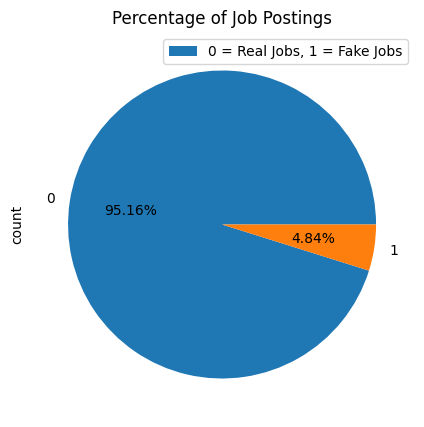

In [17]:
# data visualization
df.fraudulent.value_counts()
fig = plt.figure(figsize=(5,5))

df['fraudulent'].value_counts().plot(kind='pie',autopct='%.2f%%')
plt.title('Percentage of Job Postings')
plt.legend(labels=['0 = Real Jobs, 1 = Fake Jobs'])
plt.show()

Berdasarkan gambar diatas, insight yang dapat diperoleh adalah terdapat perbedaan yang sangat signifikan pada lowongan pekerjaan asli dan penipuan, dimana lowongan pekerjaan yang merupakan penipuan hanya 2.14% saja. Hal ini menandakan bahwa distribusinya imbalanced.

## Kedua, saya ingin melihat jumlah postingan lowongan pekerjaan asli dan penipuan terbanyak berdasarkan 'employment_type'.

In [18]:
# definition of fakejobs and realjobs
fakejobs = df[df['fraudulent'] == 1]
realjobs = df[df['fraudulent'] == 0]

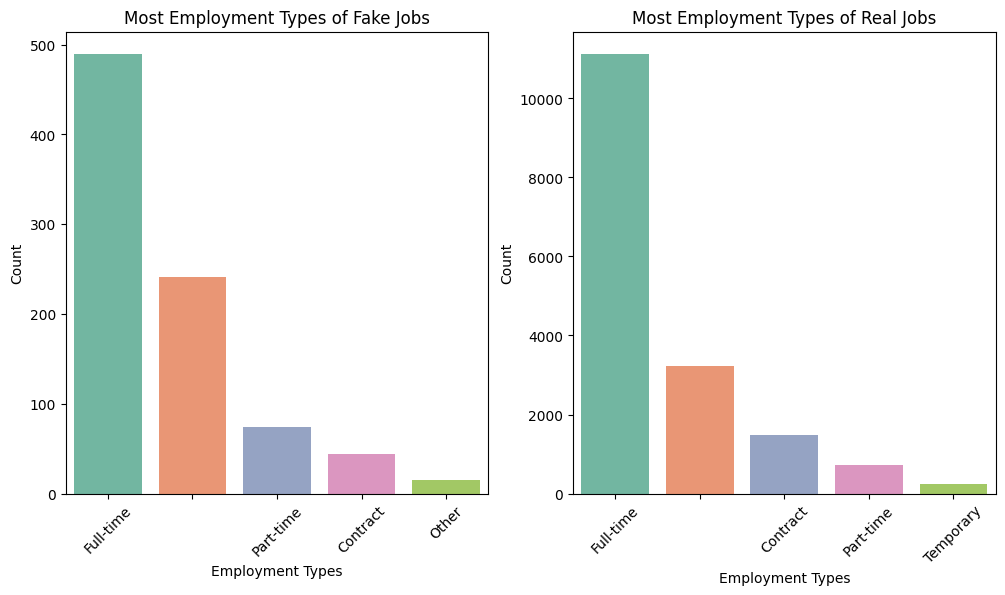

In [19]:
# data visualization
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

## fakejobs
sns.countplot(x='employment_type', data=fakejobs, palette='Set2', order=fakejobs['employment_type'].value_counts().index[:5], ax=axes[0])
axes[0].set_title('Most Employment Types of Fake Jobs')
axes[0].set_xlabel('Employment Types')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=45)

## realjobs
sns.countplot(x='employment_type', data=realjobs, palette='Set2', order=realjobs['employment_type'].value_counts().index[:5], ax=axes[1])
axes[1].set_title('Most Employment Types of Real Jobs')
axes[1].set_xlabel('Employment Types')
axes[1].set_ylabel('Count')
axes[1].tick_params(axis='x', rotation=45)

Berdasarkan gambar diatas, insight yang dapat diperoleh adalah tidak ada perbedaan yang signifikan pada lowongan pekerjaan asli dan penipuan berdasarkan jenis pekerjaannya. Hal ini mengindikasikan bahwa sulit untuk melihat apakah lowongan pekerjaan asli atau penipuan jika hanya melihat dari jenis pekerjaan saja.

## Ketiga, saya ingin melihat jumlah postingan lowongan pekerjaan asli dan penipuan terbanyak berdasarkan 'required_experience'.

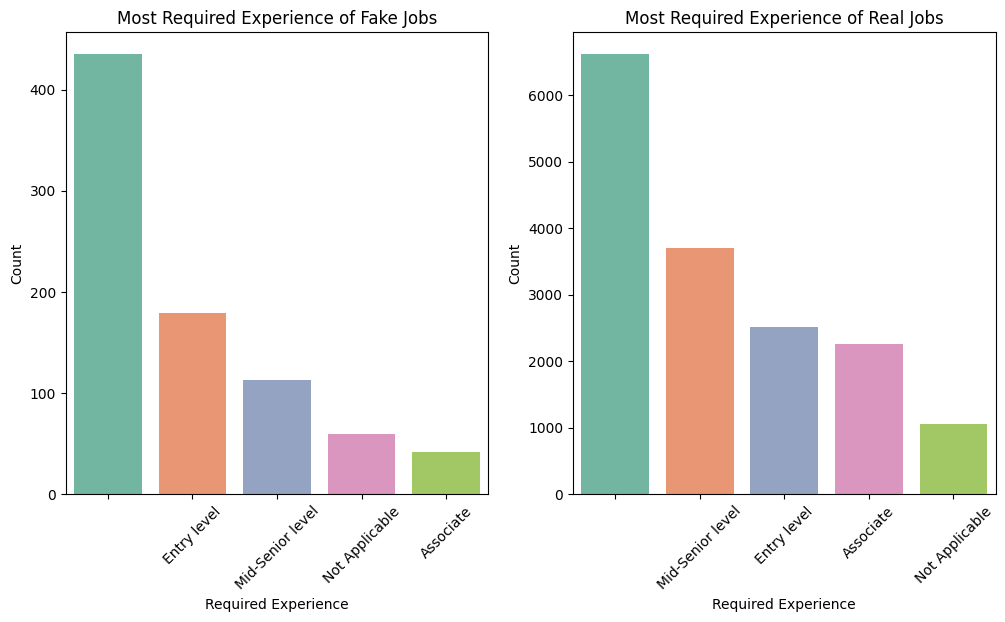

In [20]:
# data visualization
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

## fakejobs
sns.countplot(x='required_experience', data=fakejobs, palette='Set2', order=fakejobs['required_experience'].value_counts().index[:5], ax=axes[0])
axes[0].set_title('Most Required Experience of Fake Jobs')
axes[0].set_xlabel('Required Experience')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=45)

## realjobs
sns.countplot(x='required_experience', data=realjobs, palette='Set2', order=realjobs['required_experience'].value_counts().index[:5], ax=axes[1])
axes[1].set_title('Most Required Experience of Real Jobs')
axes[1].set_xlabel('Required Experience')
axes[1].set_ylabel('Count')
axes[1].tick_params(axis='x', rotation=45)

Berdasarkan gambar diatas, insight yang dapat diperoleh adalah tidak ada perbedaan yang signifikan pada lowongan pekerjaan asli dan penipuan berdasarkan pengalaman kerja. Hal ini mengindikasikan bahwa sulit untuk melihat apakah lowongan pekerjaan asli atau penipuan jika hanya melihat dari pengalaman kerja saja.

## Keempat, saya ingin melihat jumlah postingan lowongan pekerjaan asli dan penipuan terbanyak berdasarkan 'location'.

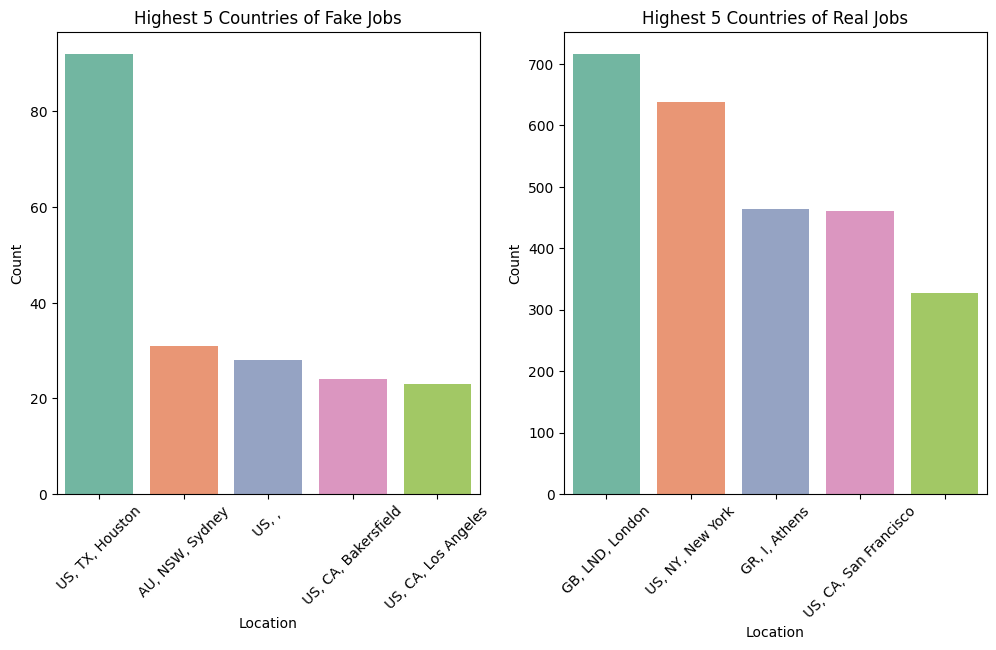

In [21]:
# data visualization
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

## fakejobs
sns.countplot(x='location', data=fakejobs, palette='Set2', order=fakejobs['location'].value_counts().index[:5], ax=axes[0])
axes[0].set_title('Highest 5 Countries of Fake Jobs')
axes[0].set_xlabel('Location')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=45)

## realjobs
sns.countplot(x='location', data=realjobs, palette='Set2', order=realjobs['location'].value_counts().index[:5], ax=axes[1])
axes[1].set_title('Highest 5 Countries of Real Jobs')
axes[1].set_xlabel('Location')
axes[1].set_ylabel('Count')
axes[1].tick_params(axis='x', rotation=45)

Berdasarkan gambar diatas, insight yang dapat diperoleh adalah target utama penipuan lowongan kerja berlokasi di negara United States, terutama di negara bagian Texas dan California. Hal ini mengindikasikan bahwa pencari kerja harus lebih berhati-hati jika lokasi perusahaan berada di Texas dan California.

# Feature Engineering

## Text Preprocessing

Text preprocessing adalah menyiapkan data teks agar dapat diolah, dimana tujuan dilakukannya hal ini adalah untuk mendapatkan informasi relevan dan penting saja sehingga mendapatkan hasil yang lebih akurat.
Pada tahap text processing, saya hanya akan menggunakan colomn 'company_profile', 'description', 'requirements' dan 'fraudulent' saja. Untuk itu, saya akan drop column yang tidak dipakai terlebih dahulu karena column lainnya tidak relevan.

In [22]:
# drop column
df.drop(['location','department','salary_range','benefits','telecommuting','has_company_logo','has_questions','employment_type','required_experience','required_education','industry','function'],axis= 1,inplace=True)

Agar lebih mudah untuk melakukan menganalisa dan melakukan preprocessing, saya akan menggabungkan column 'company_profile', 'description', dan 'requirements'.

In [23]:
# combine column 'company_profile', 'description', and 'requirements'
df['text'] = df['company_profile'] + ' ' + df['description'] + ' ' + df['requirements']

# drop column
df.drop(['company_profile','description','requirements'],axis= 1,inplace=True)

In [24]:
# show dataframe
df.head()

,fraudulent,text
0,0,"We're Food52, and we've created a groundbreaki..."
1,0,"90 Seconds, the worlds Cloud Video Production ..."
2,0,Valor Services provides Workforce Solutions th...
3,0,Our passion for improving quality of life thro...
4,0,SpotSource Solutions LLC is a Global Human Cap...


Karena dataset diambil dari job portal, terdapat kata didalam teks yang tidak kita butuhkan, seperti hashtag, link URL, dan sebagainya. Berikut adalah contoh text pada data yang harus dihilangkan.

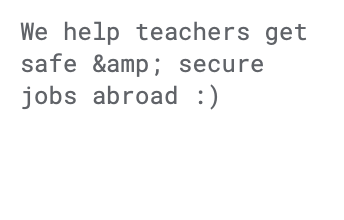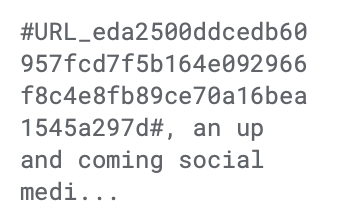

Namun, dalam text processing, saya tidak menghapus data teks yang berupa angka karena hal ini dapat mempengaruhi hasil dari pemrosesan teks tersebut. Sebagai contoh, hal ini berlaku pada lamanya pengalaman kerja yang menjadi persyaratan dalam suatu lowongan pekerjaan.

In [25]:
# create a function for text removal
def text_removal(text):
    '''
    Function to automate the deletion of unnecessary text.
    '''
    # convert text to lowercase
    text = text.lower()

    # hashtags removal
    text = re.sub(r"#\w+", " ", text)

    # newline removal (\n)
    text = re.sub(r"\n", " ", text)

    # URL removal
    text = re.sub(r"http\S+", " ", text)
    text = re.sub(r"www\S+", " ", text)

    # symbol '&' removal
    text = re.sub(r"&amp;", " ", text) #in HTML

    # punctuation removal
    text = re.sub(r"[^\w\s]", " ", text)

    # non-letter removal (such as emoticon, symbol (like μ, $, 兀), etc
    text = re.sub(r"[^A-Za-z\s']", " ", text)

    # multiple spaces removal
    text = re.sub(r"\s+", " ", text)

    # whitespace removal
    text = text.strip()

    return text

Selanjutnya adalah penghapusan stopwords, dimana stopwords adalah kata yang sering muncul namun tidak memiliki makna yang signifikan untuk analisi. Hal ini bertujuan agar dapat meningkatkan relevansi yang kata yang lebih penting.

In [26]:
# create a function for stopwords removal
def stopwords_removal(text):
    '''
    Function to automate the removal of stopwords ('and','or') and custom stopwords using the NLTK library.
    '''
    # defining stopwords
    stpwrd_eng = set(stopwords.words('english'))
    custom_stopwords = ['job','jobs','position','positions','career','careers']
    stpwrd_eng.update(custom_stopwords)

    # tokenization
    tokens = nltk.word_tokenize(text)

    # stopwords removal
    filtered_tokens = [word for word in tokens if word.lower() not in stpwrd_eng]

    # joining stopwords tokens back into a string
    cleaned_text = ' '.join(filtered_tokens)

    return cleaned_text

Pada kasus ini, saya akan melakukan proses lemmatization dengan mengembalikan sebuah kata menjadi kata dasarnya sehingga lebih mempertahankan makna secara keseluruhan. Lemmatization dirasa lebih cocok untuk digunakan dibandingkan stemming karena umumnya teks pada job posting umumnya menggunakan bahasa yang formal sehingga diperlukan grammar yang lebih dalam atau baik.
Jika kita menggunakan stemming, akan mengurangi jumlah huruf pada sebuah kata menjadi kata dasarnya sehingga untuk kasus teks dengan bahasa yang formal akan menghasilkan representasi teks yang tidak tepat.

In [27]:
# create a function for lemmatization
def lemmatization(text):
    '''
    Function to soften text by returning a word to its base (lemmatization) using the NLTK library.
    '''
    # defining lemmatizer
    lemmatizer = WordNetLemmatizer()

    # tokenization
    tokens = nltk.word_tokenize(text)

    # lemmatization
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # joining lemmatized tokens back into a string
    lemmatized_text = ' '.join(lemmatized_tokens)

    return lemmatized_text

Selanjutnya adalah menggabungkan hasil text prossessing yang telah dilakukan sebelumnya untuk mendapatkan jumlah vocabulary yang relevan.

In [28]:
# combining tokens from preprocess
def text_preprocessing(text):
    '''
    Function to combine the results of text removal, stopwords removal, and lemmatization.
    '''
    text = text_removal(text)
    text = stopwords_removal(text)
    text = lemmatization(text)
    return text

Lalu, saya akan membuat column baru untuk memasukkan teks yang sudah dibersihkan pada preproses.

In [29]:
# applying text preprocessing to the dataset
df['text_processed'] = df['text'].apply(lambda x: text_preprocessing(x))
df

,fraudulent,text,text_processed
0,0,"We're Food52, and we've created a groundbreaki...",food created groundbreaking award winning cook...
1,0,"90 Seconds, the worlds Cloud Video Production ...",second world cloud video production service se...
2,0,Valor Services provides Workforce Solutions th...,valor service provides workforce solution meet...
3,0,Our passion for improving quality of life thro...,passion improving quality life geography heart...
4,0,SpotSource Solutions LLC is a Global Human Cap...,spotsource solution llc global human capital m...
...,...,...,...
17875,0,Vend is looking for some awesome new talent to...,vend looking awesome new talent come join u wo...
17876,0,WebLinc is the e-commerce platform and service...,weblinc e commerce platform service provider f...
17877,0,We Provide Full Time Permanent Positions for m...,provide full time permanent many medium large ...
17878,0,Nemsia Studios is looking for an experienced...,nemsia studio looking experienced visual graph...


In [30]:
# get vocabularies
vectorize = CountVectorizer()
text_before = vectorize.fit_transform(df['text'])
text_preprocessed_before = vectorize.fit_transform(df['text_processed'])

print(text_before.shape,text_preprocessed_before.shape)

(17880, 96961) (17880, 84288)


Berdasarkan hasil diatas, `jumlah token atau kata unik yang dihasilkan setelah melakukan text preprocessed sudah berkurang dibandingkan sebelumnya`. Pengurangan jumlah token ini akan berguna dalam melakukan pengolahan data teks agar mengurangi waktu pemerosesan dan juga memori yang digunakan lebih sedikit.

## Preprocessed Data Visualization

Berikut adalah hasil visualisasi teks dari fake job posting dan real job posting, dimana tujuannya adalah untuk mengetahui ciri-ciri job posting asli dan penipuan berdasarkan teks yang sering keluar.

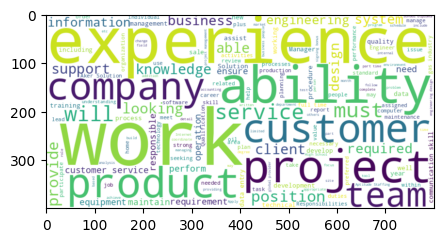

In [31]:
# text visualization for fake jobs
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(" ".join(df[df.fraudulent == 1].text))
plt.figure(figsize=(5,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis()
plt.show()

Dari visualisasi diatas, dapat dilihat bahwa kata yang sering muncul sangat banyak, dimana `tidak ada dominasi kata yang signifikan jumlahnya`. Hal ini dapat menandakan bahwa salah satu ciri sebuah lowongan pekerjaan merupakan penipuan adalah deskripsi pekerjaan yang terlalu umum dan tidak adanya informasi yang jelas mengenai tanggung jawab atau requirements yang diperlukan.

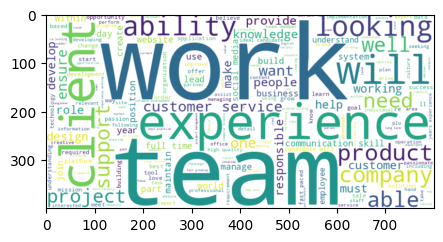

In [32]:
# text visualization for real jobs
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(" ".join(df[df.fraudulent == 0].text))
plt.figure(figsize=(5,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis()
plt.show()

Dari hasil visualisasi untuk lowongan pekerjaan asli, kita dapat melihat bahwa terdapat perbedaan yang sangat jelas jika dibandingkan dengan lowongan pekerjaan penipuan, yaitu terdapat kata yang sangat mendominasi, yaitu `team, work, experience, dan client`. Hal ini menandakan bahwa ciri-ciri sebuah lowongan pekerjaan merupakan asli adalah terdapat informasi yang jelas tentang tanggung jawab dan fokus pekerjaan, khususnya hubungan dengan client. Oleh karena itu, 'client' disini menjadi kata crucial yang dapat membedakan keaslian postingan lowongan pekerjaan.

## Target Conversion

In [33]:
# show target
df.fraudulent.unique()

array([0, 1])

Dalam hal ini, target sudah dalam bentuk numerik sehingga tidak perlu dikonversikan dan membuat column baru.

## Split Feature as `x` and Label as `y`

Dalam hal ini, label nya adalah 'fraudulent' dimana kita ingin mengetahui apakah postingan lowongan pekerjaan tersebut asli atau penipuan.

In [34]:
# split feature with target/label
X = df['text_processed'] #feature
y = df['fraudulent'] #label

## Split Train-set, Validation-set, and Test-set

selanjutnya adalah membagi data menjadi train-set dan validation-set untuk dilakukan training, dan test-set untuk testing.

In [35]:
# splitting between train-set, val-set, and test-set
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, stratify=y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.15, random_state=42)

print('Train Size : ', X_train.shape)
print('Val Size   : ', X_val.shape)
print('Test Size  : ', X_test.shape)

Train Size :  (12918,)
Val Size   :  (2280,)
Test Size  :  (2682,)


## Text Vectorization

Text vectorization adalah proses penting dalam natural language processing (NLP) yang mengubah teks menjadi bentuk numerik agar dapat diproses dan dianalisis oleh model machine learning. Proses ini melibatkan penghitungan frekuensi kata dalam dokumen untuk membangun representasi numerik yang dapat digunakan oleh model untuk melakukan klasifikasi. Dengan cara ini, machine learning dapat menganalisis dan memahami teks dalam jumlah besar secara cepat dan akurat. Dalam hal ini, saya akan menggunakan CountVectorizer untuk mengubah teks menjadi angka.

In [36]:
# get vocabularies after text prepocessed
vectorize = CountVectorizer()
X_train_vec = vectorize.fit_transform(X_train)
X_test_vec = vectorize.transform(X_test)

X_train_vec

<12918x70165 sparse matrix of type '<class 'numpy.int64'>'
	with 1977832 stored elements in Compressed Sparse Row format>

In [37]:
# finding the number of vocabs and max token length in one document
total_vocab = len(vectorize.vocabulary_.keys())
max_sen_len = max([len(i.split(" ")) for i in X_train])

print('Total Vocab : ', total_vocab)
print('Maximum Sentence Length : ', max_sen_len, 'tokens')

Total Vocab :  70165
Maximum Sentence Length :  1398 tokens


Berdasarkan hasil perhitungan, dapat dilihat bawa setelah text preprocessed pada X_train adalah sebagai berikut
- 12918 data entries atau dokumen.
- 70165 vocabulary, dimana vocabulary adalah jumlah unique token atau kata yang ada dalam data.
- 1977832 jumlah elemen tersimpan, artinya akan ada 1977832 data yang akan di training.
- Kalimat terpanjang dalam satu dokumen memiliki 1398 kata atau token.

In [38]:
# text vectorization
text_vectorization = TextVectorization(max_tokens=total_vocab,
                                       standardize="lower_and_strip_punctuation",
                                       split="whitespace",
                                       ngrams=None,
                                       output_mode="int",
                                       output_sequence_length=max_sen_len,
                                       input_shape=(1,)) #for Sequential API

text_vectorization.adapt(X_train)

Berikut adalah contoh dokumen yang telah dilakukan, hasil text vectorization dari dokumen tersebut, dan vector sizenya.

In [39]:
# example result
## document example
print('Document example')
print(df.text_processed[0])
print('')

## result of text vectorization
print('Result of Text Vectorization')
print(text_vectorization([df.text_processed[0]]))
print('Vector size : ', text_vectorization([df.text_processed[0]]).shape)

Document example
food created groundbreaking award winning cooking site support connect celebrate home cook give everything need one place top editorial business engineering team focused using technology find new better way connect people around specific food interest offer superb highly curated information food cooking attract talented home cook contributor country also publish well known professional like mario batali gwyneth paltrow danny meyer partnership whole food market random house food named best food website james beard foundation iacp featured new york time npr pando daily techcrunch today show located chelsea new york city food fast growing james beard award winning online food community crowd sourced curated recipe hub currently interviewing full part time unpaid intern work small team editor executive developer new york city headquarters reproducing repackaging existing food content number partner site huffington post yahoo buzzfeed various content management systemsresea

Berikut adalah 20 vocab paling yang sering muncul.

In [40]:
# view the top 20 tokens (sorted by the highest frequency of appearance)
text_vectorization.get_vocabulary()[:20]

['',
 '[UNK]',
 'experience',
 'team',
 'work',
 'service',
 'customer',
 'company',
 'business',
 'client',
 'skill',
 'product',
 'year',
 'new',
 'management',
 'development',
 'sale',
 'project',
 'technology',
 'working']

## Word Embeding

Selanjutnya adalah melakukan word embeding dengan mengubah vocab menjadi numerik agar dapat diolah menjadi bahasa manusia atau Natural Language Processing (NLP), dimana tujuanya adalah untuk memahami hubungan antar vocab.

Dalam hal ini, saya akan menginisialisasi bobot embeddings dengan nilai acak dari distribusi seragam, dimana setiap nilai dalam matriks embedding untuk setiap kata akan dipilih secara acak dari rentang yang sama antara nilai minimum dan maksimum yang ditentukan. Alasan penggunaan 'uniform' adalah karena umum digunakan dan sederhana.

In [41]:
# embedding
embedding = Embedding(input_dim=total_vocab,
                      output_dim=128,
                      embeddings_initializer="uniform", #initialized with random values ​​from a uniform distribution.
                      input_length=max_sen_len)

In [42]:
# example result
## document example
print('Document example')
print(df.text_processed[0])
print('')

## result of text vectorization
print('Result of  Text Vectorization')
print(text_vectorization([df.text_processed[0]]))
print('Vector size : ', text_vectorization([df.text_processed[0]]).shape)
print('')

## result of embedding
print('Result of  Embedding')
print(embedding(text_vectorization([df.text_processed[0]])))
print('Vector size : ', embedding(text_vectorization([df.text_processed[0]])).shape)

Document example
food created groundbreaking award winning cooking site support connect celebrate home cook give everything need one place top editorial business engineering team focused using technology find new better way connect people around specific food interest offer superb highly curated information food cooking attract talented home cook contributor country also publish well known professional like mario batali gwyneth paltrow danny meyer partnership whole food market random house food named best food website james beard foundation iacp featured new york time npr pando daily techcrunch today show located chelsea new york city food fast growing james beard award winning online food community crowd sourced curated recipe hub currently interviewing full part time unpaid intern work small team editor executive developer new york city headquarters reproducing repackaging existing food content number partner site huffington post yahoo buzzfeed various content management systemsresea

# Artificial Neural Network (ANN) Training: Sequential API

Untuk melakukan training, saya akan menggunakan Model Sequential karena model sequential adalah cara paling sederhana untuk membuat model Artificial Neural Network (ANN), dimana layer akan ditambahkan secara berurutan satu persatu. Pada model ini setiap hidden layer terdiri dari neuron yang mengambil input dari layer sebelumnya dan menghasilkan output yang diteruskan ke layer berikutnya.
Dalam hal ini, saya akan mencoba membuat model dengan layer embeding LSTM yang akan digunakan untuk memproses urutan input dengan menentukan unis pada hidden layer.

## Model Definition

Pertama, saya akan membuat clear session supaya ketika running ulang maka model akan melakukan training dari awal atau 0.

In [43]:
# clear session
seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

Long Short-Term Memory (LSTM) adalah inovasi dalam pengembangan model RNN karena menggunakan strukrtur 3 gate (forget gate, input gate, output gate), dimana hal ini sangat bermanfaat dalam memahami dan memproses data sequential dengan lebih efektif dan akurat. Tujuan dari menggunakan LSTM adalah untuk mengatasi masalah vanishing gradient yang sering terjadi pada RNN konvensional. Dalam hal ini, saya akan menggunakan LSTM pada hidden layer dan Dense pada output layer.
Berikut adalah penjelasan detail parameter architecturenya:
- Menggunakan activation function 'sigmoid' karena targetnya merupakan binary classification.
- Menggunakan kernel initializer 'GlorotUniform' karena distribusi targetnya tidak simetris
- Menggunakan 'Dropout' untuk reduce overfitting.

In [44]:
# create architecture sequential
model_lstm = Sequential()

model_lstm.add(text_vectorization)
model_lstm.add(embedding)

# create hidden layer 1
model_lstm.add(LSTM(32,
                    return_sequences=True,
                    kernel_initializer=tf.keras.initializers.GlorotUniform(seed)))
model_lstm.add(Dropout(0.1)) #to reduce overfitting

# create hidden layer 2
model_lstm.add(LSTM(16,
                    kernel_initializer=tf.keras.initializers.GlorotUniform(seed)))
model_lstm.add(Dropout(0.1))

# create output layer for binary classification
model_lstm.add(Dense(1,
                     activation='sigmoid'))

Berikut adalah summary dan visualization setap lapisan dari model sequential LSTM.

In [45]:
# show model summary
model_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, 1398)              0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 1398, 128)         8981120   
                                                                 
 lstm (LSTM)                 (None, 1398, 32)          20608     
                                                                 
 dropout (Dropout)           (None, 1398, 32)          0         
                                                                 
 lstm_1 (LSTM)               (None, 16)                3136      
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                        

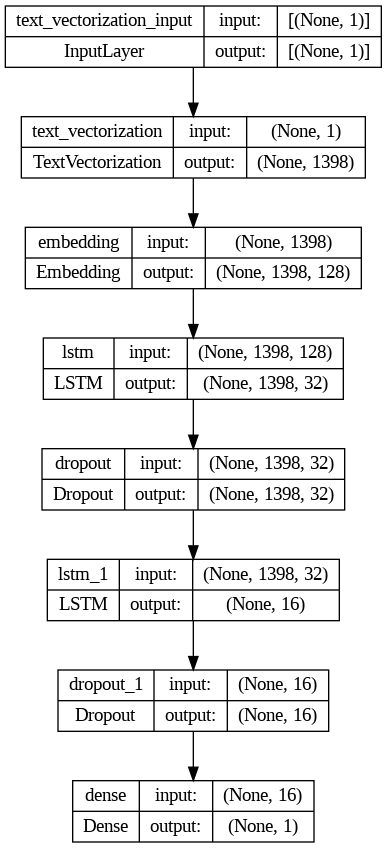

In [46]:
# plot layers
tf.keras.utils.plot_model(model_lstm,show_shapes=True)

Selanjutnya adalah compile model sebelum melakukan training dengan mengatur parameter yang sesuai. Berikut adalah alasan pemilihan parameternya:
- binary_crossentropy: karena target/labelnya adalah 0 dan 1.
- adam: rule of thumb optimizer untuk mengurangi error.
- metrics: recall karena ingin meminimalisir false negative.

In [47]:
# compile model
model_lstm.compile(loss='binary_crossentropy', #for binary classification
                   optimizer='adam', #rule of thumb
                   metrics=['Recall'])

## Model Training

Sebelum melakukan training, saya membuat callback EarlyStopping yang berfungsi untuk menghentikan model training secara otomatis ketika suatu metrik pengawasan (monitor) tidak membaik performancenya dalam beberapa kali percobaan (patience).
Dalam hal ini, callback akan memantau nilai loss pada data validasi (val_loss) dan akan menghentikan model training jika performance val_loss tidak membaik setelah 5 kali percobaan.

In [48]:
# set early stopping as callback
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=5,
                                            restore_best_weights=True)

Selanjutnya, pelatihan akan dilakukan selama 30 epoch untuk melatih X_train dan y_train.

In [49]:
# model training
%%time
history_model_lstm = model_lstm.fit(X_train, y_train,
                                    epochs=30,
                                    validation_data=(X_val, y_val),
                                    batch_size=32,
                                    callbacks=callback)

Epoch 1/30
404/404 [==============================] - 70s 158ms/step - loss: 0.2115 - recall: 0.0000e+00 - val_loss: 0.1868 - val_recall: 0.0000e+00
Epoch 2/30
404/404 [==============================] - 50s 123ms/step - loss: 0.1976 - recall: 0.0000e+00 - val_loss: 0.1868 - val_recall: 0.0000e+00
Epoch 3/30
404/404 [==============================] - 42s 105ms/step - loss: 0.1978 - recall: 0.0000e+00 - val_loss: 0.1871 - val_recall: 0.0000e+00
Epoch 4/30
404/404 [==============================] - 40s 98ms/step - loss: 0.1968 - recall: 0.0000e+00 - val_loss: 0.1873 - val_recall: 0.0000e+00
Epoch 5/30
404/404 [==============================] - 39s 96ms/step - loss: 0.1980 - recall: 0.0000e+00 - val_loss: 0.1867 - val_recall: 0.0000e+00
Epoch 6/30
404/404 [==============================] - 36s 90ms/step - loss: 0.1974 - recall: 0.0000e+00 - val_loss: 0.1876 - val_recall: 0.0000e+00
Epoch 7/30
404/404 [==============================] - 36s 88ms/step - loss: 0.1971 - recall: 0.0000e+00 - val

Training berhasil dilakukan dengan total running time 9m 15s.

In [50]:
# save history to dataframe
df_history_model_lstm = pd.DataFrame(history_model_lstm.history)

Berikut adalah visualisasi learning curve dari model sequential untuk melihat apakah model termasuk goodfit, underfitting, atau overfitting.

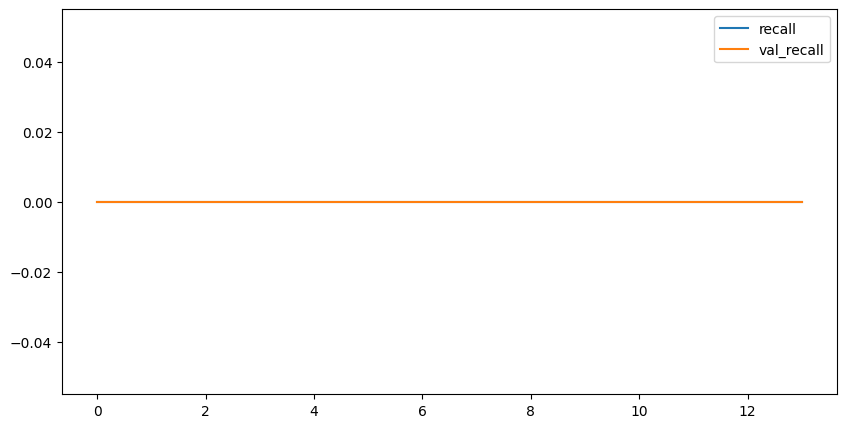

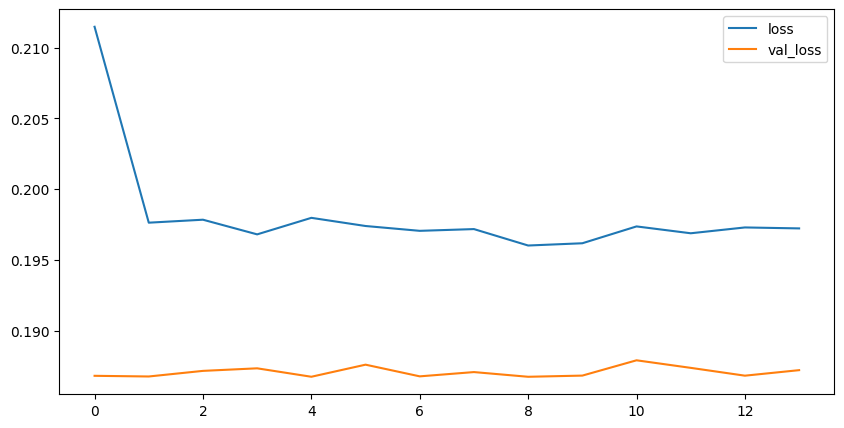

In [51]:
# plot training result
df_history_model_lstm[['recall', 'val_recall']].plot(figsize=(10, 5))
df_history_model_lstm[['loss', 'val_loss']].plot(figsize=(10, 5))
plt.show()

Berdasarkan hasil recall score, hasil menunjukkan performance recall score yang buruk. Hal ini kemungkinan besar disebabkan oleh `ketidakseimbangan data, sehingga hasil model menunjukkan underfitting`. Oleh karena itu, saya akan mencoba melakukan improvement dengan menggunakan transfer learning untuk melihat apakah terjadi peningkatan pada nilai recall, dan membandingkannya dengan hasil sebelum menggunakan transfer learning.

## Model Evaluation

In [52]:
# predict model to train-set
y_pred_train = model_lstm.predict(X_train)

# set classification threshold to convert probability into class
y_pred_train = np.where(y_pred_train >= 0.5, 1, 0)

# classification report
print(classification_report(y_train, y_pred_train))

# define confusion matrix
cm_train = confusion_matrix(y_train, y_pred_train)

# confusion matrix to extract False Negative
fn_train = cm_train[1][0]
print(f"False Negatives: {fn_train}")

404/404 [==============================] - 15s 35ms/step
              precision    recall  f1-score   support

           0       0.95      1.00      0.97     12287
           1       0.00      0.00      0.00       631

    accuracy                           0.95     12918
   macro avg       0.48      0.50      0.49     12918
weighted avg       0.90      0.95      0.93     12918

False Negatives: 631


In [53]:
# predict model to test-set
y_pred_test = model_lstm.predict(X_test)

# set classification threshold to convert probability into class
y_pred_test = np.where(y_pred_test >= 0.5, 1, 0)

# classification report
print(classification_report(y_test, y_pred_test))

# define confusion matrix
cm_test = confusion_matrix(y_test, y_pred_test)

# confusion matrix to extract False Negative
fn_test = cm_test[1][0]
print(f"False Negatives: {fn_test}")

84/84 [==============================] - 3s 32ms/step
              precision    recall  f1-score   support

           0       0.95      1.00      0.98      2552
           1       0.00      0.00      0.00       130

    accuracy                           0.95      2682
   macro avg       0.48      0.50      0.49      2682
weighted avg       0.91      0.95      0.93      2682

False Negatives: 130


Dari hasil evaluasi, dapat dilihat bahwa hasil recall score untuk memprediksi penipuan lowongan pekerjaan masih dibawah 1%, dengan false negative pada X_train dan X_test adalah 631 dan 130.

# Artificial Neural Network (ANN) Improvement: Sequential API

Untuk improvement model, saya akan mencoba menggunakan transfer learning.
Transfer learning dalam deep learning memungkinkan penggunaan pengetahuan yang sudah ada dari pemecahan satu tugas untuk membantu memecahkan tugas lain yang berhubungan atau serupa. Dengan cara ini, kita dapat meningkatkan kinerja model dalam memahami dan menyelesaikan masalah baru menggunakan pengetahuan yang sudah ada sehingga dapat menghemat waktu dan sumber daya yang diperlukan untuk pelatihan model dari awal.

## Model Improvement Definition

Untuk model improvement, saya akan mencoba menerapkan transfer learning dengan menambahkan embedding layer.
Embedding layer, khususnya dalam konteks pemrosesan bahasa alami (NLP), merupakan komponen penting dalam model neural network yang memetakan kata-kata ke dalam representasi vektor numerik yang bermakna. Hal ini memungkinkan model untuk memahami hubungan antar kata dan konteks kalimat secara lebih baik, dengan memanfaatkan embeddings yang sudah dipelajari sebelumnya atau dipelajari selama proses pelatihan model.
Tujuan dari penggunaan transfer learning dan embeding layer adalah untuk dapat membangun dan meningkatkan model NLP secara efisien.

In [54]:
# download the embedding layer
url = 'https://tfhub.dev/google/tf2-preview/nnlm-en-dim128-with-normalization/1'
hub_layer = tf_hub.KerasLayer(url, output_shape=[128], input_shape=[], dtype=tf.string)

Saya juga akan membuat clear session pada model improvement supaya ketika running ulang maka model akan melakukan training dari awal atau 0.

In [55]:
# clear session
seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

Pada model improvement, saya akan menerapkan 'hub_layer' untuk embedding dan 'Reshape' untuk menyesuaikan input dari layer sebelumnya, dimana hasil akhir dari Reshape sesuai dengan input yang diharapkan oleh lapisan berikutnya.

In [56]:
# create architecture sequential
improve_model_lstm = Sequential()

improve_model_lstm.add(hub_layer)
improve_model_lstm.add(Reshape((128, 1)))

# create hidden layer 1
improve_model_lstm.add(LSTM(32,
                    return_sequences=True,
                    kernel_initializer=tf.keras.initializers.GlorotUniform(seed)))
improve_model_lstm.add(Dropout(0.1)) #to reduce overfitting

# create hidden layer 2
improve_model_lstm.add(LSTM(16,
                    kernel_initializer=tf.keras.initializers.GlorotUniform(seed)))
improve_model_lstm.add(Dropout(0.1))

# create output layer for binary classification
improve_model_lstm.add(Dense(1,
                     activation='sigmoid')) #for binary classification

Berikut adalah summary dan visualization setap lapisan dari model improvement.

In [57]:
# show model improvement summary
improve_model_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 128)               124642688 
                                                                 
 reshape (Reshape)           (None, 128, 1)            0         
                                                                 
 lstm (LSTM)                 (None, 128, 32)           4352      
                                                                 
 dropout (Dropout)           (None, 128, 32)           0         
                                                                 
 lstm_1 (LSTM)               (None, 16)                3136      
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense (Dense)               (None, 1)                 1

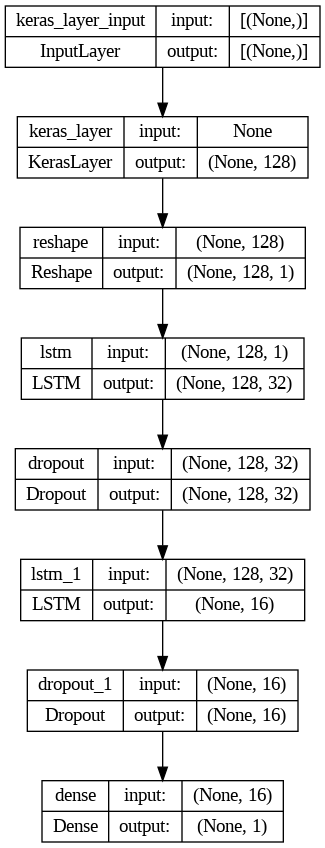

In [58]:
# plot layers improvement
tf.keras.utils.plot_model(improve_model_lstm,show_shapes=True)

Untuk compile model, parameter model improvement sama dengan model sebelumnya.

In [59]:
# compile model improvement
improve_model_lstm.compile(loss='binary_crossentropy', #for binary classification
                           optimizer='adam', #rule of thumb
                           metrics=['recall'])

## Model Improvement Training

Untuk training model improvement, saya juga membuat callback EarlyStopping yang sama dengan model sebelumnya, dimana akan menghentikan model training jika performance val_loss tidak membaik setelah 5 kali percobaan.

In [60]:
# set early stopping as callback
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=5,
                                            restore_best_weights=True)

Selanjutnya, pelatihan akan dilakukan selama 30 epoch untuk melatih X_train dan y_train.

In [61]:
# model training
%%time
history_improve_model_lstm = model_lstm.fit(X_train, y_train,
                                            epochs=30,
                                            validation_data=(X_val, y_val),
                                            batch_size=32,
                                            callbacks=callback)

Epoch 1/30
404/404 [==============================] - 36s 88ms/step - loss: 0.1980 - recall: 0.0000e+00 - val_loss: 0.1867 - val_recall: 0.0000e+00
Epoch 2/30
404/404 [==============================] - 33s 81ms/step - loss: 0.1966 - recall: 0.0000e+00 - val_loss: 0.1868 - val_recall: 0.0000e+00
Epoch 3/30
404/404 [==============================] - 34s 84ms/step - loss: 0.1967 - recall: 0.0000e+00 - val_loss: 0.1869 - val_recall: 0.0000e+00
Epoch 4/30
404/404 [==============================] - 36s 88ms/step - loss: 0.1958 - recall: 0.0000e+00 - val_loss: 0.1870 - val_recall: 0.0000e+00
Epoch 5/30
404/404 [==============================] - 34s 83ms/step - loss: 0.1971 - recall: 0.0000e+00 - val_loss: 0.1867 - val_recall: 0.0000e+00
Epoch 6/30
404/404 [==============================] - 34s 84ms/step - loss: 0.1966 - recall: 0.0000e+00 - val_loss: 0.1873 - val_recall: 0.0000e+00
Epoch 7/30
404/404 [==============================] - 36s 89ms/step - loss: 0.1968 - recall: 0.0000e+00 - val_lo

Training berhasil dilakukan dengan total running time 5m 43s.

In [62]:
# save history to dataframe
df_history_improve_model_lstm = pd.DataFrame(history_improve_model_lstm.history)

Berikut adalah visualisasi learning curve dari model improvement untuk melihat apakah model termasuk goodfit, underfitting, atau overfitting.

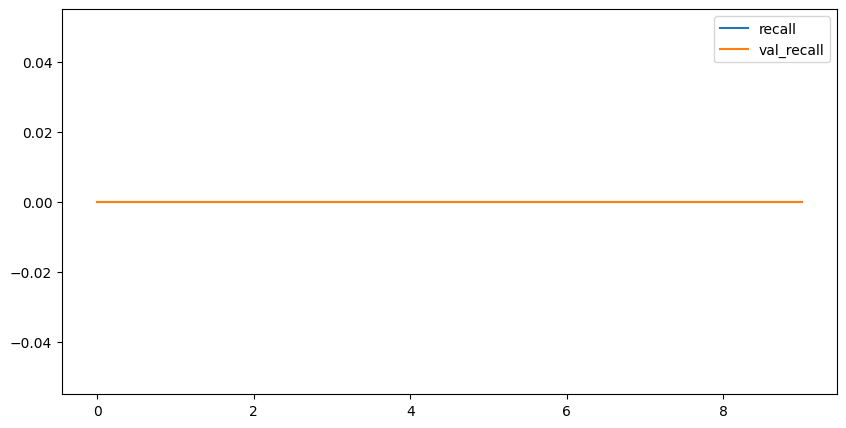

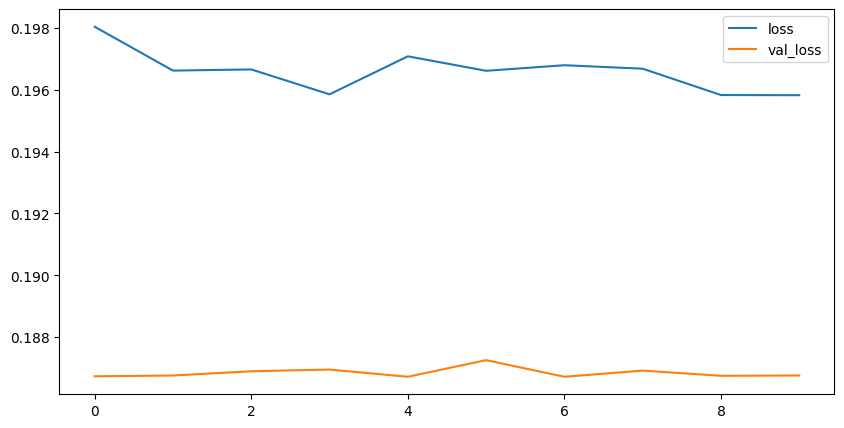

In [63]:
# plot training result
df_history_improve_model_lstm[['recall', 'val_recall']].plot(figsize=(10, 5))
df_history_improve_model_lstm[['loss', 'val_loss']].plot(figsize=(10, 5))
plt.show()

Berdasarkan hasil improvement, meskipun gap sudah mengecil tetapi `model tetap dikategorikan sebagai underfiting yang kemungkinan disebabkan oleh ketidakseimbangan data`, seperti yang telah saya jelaskan sebelumnya.

## Model Improvement Evaluation

In [64]:
# predict model to train-set
y_pred_train = improve_model_lstm.predict(X_train)

# set classification threshold to convert probability into class
y_pred_train = np.where(y_pred_train >= 0.5, 1, 0)

# classification report
print(classification_report(y_train, y_pred_train))

# define confusion matrix
cm_train = confusion_matrix(y_train, y_pred_train)

# confusion matrix to extract False Negative
fn_train = cm_train[1][0]
print(f"False Negatives - Improvement: {fn_train}")

404/404 [==============================] - 4s 7ms/step
              precision    recall  f1-score   support

           0       0.95      0.70      0.81     12287
           1       0.05      0.34      0.09       631

    accuracy                           0.68     12918
   macro avg       0.50      0.52      0.45     12918
weighted avg       0.91      0.68      0.77     12918

False Negatives - Improvement: 417


In [65]:
# predict model to test-set
y_pred_test = improve_model_lstm.predict(X_test)

# set classification threshold to convert probability into class
y_pred_test = np.where(y_pred_test >= 0.5, 1, 0)

# classification report
print(classification_report(y_test, y_pred_test))

# define confusion matrix
cm_test = confusion_matrix(y_test, y_pred_test)

# confusion matrix to extract False Negative
fn_test = cm_test[1][0]
print(f"False Negatives - Improvement: {fn_test}")

84/84 [==============================] - 1s 7ms/step
              precision    recall  f1-score   support

           0       0.95      0.71      0.81      2552
           1       0.04      0.26      0.07       130

    accuracy                           0.69      2682
   macro avg       0.50      0.48      0.44      2682
weighted avg       0.91      0.69      0.78      2682

False Negatives - Improvement: 96


Dari hasil evaluasi, meskipun hasil recall score masih dibawah 50%, tetapi terdapat improvement pada hasil X_train dan X_test yang dapat dilihat dari peningkatan hasil recall score dan penurunan false negatif.

# Model Saving

Dari hasil evaluasi, terdapat improvement setelah melakukan transfer learning dan embeding layer. Oleh karena itu, kita save best modelnya yaitu 'improve_model_lstm'.

In [66]:
# show model summary
improve_model_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 128)               124642688 
                                                                 
 reshape (Reshape)           (None, 128, 1)            0         
                                                                 
 lstm (LSTM)                 (None, 128, 32)           4352      
                                                                 
 dropout (Dropout)           (None, 128, 32)           0         
                                                                 
 lstm_1 (LSTM)               (None, 16)                3136      
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense (Dense)               (None, 1)                 1

Sebelum save model, kita harus membuat trainable parameter menjadi 0.

In [67]:
# freeze model
improve_model_lstm.trainable = False
improve_model_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 128)               124642688 
                                                                 
 reshape (Reshape)           (None, 128, 1)            0         
                                                                 
 lstm (LSTM)                 (None, 128, 32)           4352      
                                                                 
 dropout (Dropout)           (None, 128, 32)           0         
                                                                 
 lstm_1 (LSTM)               (None, 16)                3136      
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense (Dense)               (None, 1)                 1

In [68]:
# save model
improve_model_lstm.save('improve_model_lstm.keras')
model_lstm.save('model_lstm.keras')

# Model Inference

File notebook untuk model inference dibuat terpisah pada notebook `P2G7_divani_rafitya_inference.ipynb` karena pada notebook ini terdapat data bersifat rahasia yang berisikan data-data confidential.

# Conclusion

Berdasarkan insight yang diperoleh dari hasil exploratory data analisys, sebagian besar lowongan pekerjaan yang tersedia adalah legit dan dapat dipercaya, dengan `hanya sekitar 2.14% yang terindikasi sebagai penipuan`. Penipuan ini memiliki kecenderungan yang terpusat di Amerika Serikat, khususnya di Texas dan California. 

Selanjutnya, jika kita melihat dari visualisasi teks setelah preprocessing, kata yang sering muncul sangat banyak dan `tidak ada dominasi kata yang signifikan jumlahnya pada hasil teks postingan lowongan pekerjaan penipuan`. Hal ini dapat menandakan bahwa salah satu ciri lowongan pekerjaan penipuan adalah deskripsi pekerjaan yang terlalu umum dan tidak adanya informasi yang jelas mengenai tanggung jawab atau requirements yang diperlukan.
Sedangkan, terdapat perbedaan yang sangat jelas karena `adanya dominasi kata yang sering muncul pada hasil teks postingan lowongan pekerjaan asli`, yaitu team, work, experience, dan client. Hal ini menandakan bahwa ciri-ciri lowongan pekerjaan asli adalah terdapat informasi yang jelas tentang tanggung jawab dan fokus pekerjaan, khususnya hubungan dengan client. Oleh karena itu, client disini menjadi kata crucial yang dapat membedakan keaslian postingan lowongan pekerjaan.

Dalam hal ini, saya membuat deep learning model yang dapat mengidentifikasi postingan lowongan kerja penipuan menggunakan Natural Language Preprocessing (NLP) untuk dapat mengurangi risiko penipuan lowongan kerja. Hal ini bertujuan untuk memastikan bahwa pencari kerja mendapatkan lowongan pekerjaan yang sesungguhnya dari perusahaan dan tidak kehilangan kesempatan untuk memperoleh pekerjaan yang layak.

Berdasarkan model yang telah dibuat, berikut adalah ringkasannya:

Before Improvement:
- X_train recall score: < 1%
- X_test recall score: < 1%
- X_train false negative: 631
- X_test false negative: 130

After Improvement with Transfer Learning:
- X_train recall score: 34%
- X_test recall score: 26%
- X_train false negative: 417
- X_test false negative: 96

Berdasarkan hasil evaluasi, model masih memiliki kekurangan karena hasil setelah improvement menggunakan transfer learning `model masih underfitting`. Artinya, performance model saat training dan testing masih buruk sehingga belum bisa memprediksi lowongan pekerjaan penipuan dengan baik. Hal ini kemungkinan disebabkan oleh `distribusi data lowongan pekerjaan asli dan penipuan yang imbalanced sehingga masih bias terhadap lowongan pekerjaan yang asli karena variasi data yang lebih banyak`.
Menurut saya, kelemahan ini juga dapat dimaklumi karena kita sebagai `manusia pun belum tentu bisa membedakan secara jelas` jika kita melihat sebuah postingan lowongan pekerjaan, apakah lowongan tersebut asli atau penipuan, dimana kita harus memvalidasi informasi tersebut terlebih dahulu.

Meskipun setelah melakukan improvement model termasuk underfitting, berikut adalah kelebihan model yang telah dibuat setelah melakukan improvement dengan transfer learning:
- Meskipun hasil recall score masih dibawah 50%, tetapi terdapat improvement pada hasil X_train dan X_test yang dapat dilihat dari `peningkatan hasil test recall score dari 0% menjadi 26%`, dan `penurunan hasil test false negatif dari 130 menjadi 96`. Hal ini menandakan bahwa model yang sebelumnya sama sekali tidak bisa memprediksi postingan lowongan pekerjaan (0%) menjadi bisa memprediksi walaupun masih belum baik performancenya.
- Runtime setelah improvement dengan transfer learning lebih cepat, dari yang sebelumnya `9min 15s menjadi 5min 43s`.
- `Tidak ada data leakage`, karena tidak melakukan training data yang ada pada data testing.

Untuk itu, rekomendasi hal yang dapat di improve pada model untuk mendapatkan hasil performance yang lebih baik atau goodfit adalah sebagai berikut:
- Melatih lebih banyak data dengan `menambah jumlah data untuk lowongan pekerjaan penipuan`, karena pada dataset saat ini jumlah postingan lowongan kerja asli dan penipuan imbalanced. Hal ini dilakukan untuk membantu model dalam melakukan training dengan variasi atau pola yang lebih banyak.
- `Menambah kapasitas model` agar model dapat mempelajari variasi atau pola yang lebih banyak dalam data. Hal ini dapat dilakukan dengan cara menambahkan jumlah hidden layer dan ukuran dense layer pada jaringan neural networknya (ANN).

Oleh karena itu, rekomendasinya adalah agar pencari kerja lebih berhati-hati ketika melamar di perusahaan-perusahaan yang berbasis di negara bagian tersebut, salah satunya adalah dengan memeriksa apakah lowongan pekerjaan tersebut asli atau penipuan berdasarkan company profile, job description, job requirement, dan sebagainya. Oleh karena itu, penting untuk memvalidasi apakah informasi tersebut adalah benar dan mengetahui isi text pada setiap lowongan pekerjaan yang ada untuk mengetahui apakah lowongan pekerjaan tersebut asli atau penipuan.